In [220]:
import pandas as pd
import random
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import csv
from sklearn.cluster import DBSCAN
import math
import statistics
from sklearn import metrics
pd.options.mode.chained_assignment = None  # default='warn'

#Convert CSV to Dataframe
data = pd.read_csv("./data/iou-dsc.csv", header=[0]).replace('\n','', regex=True)
data

,IN FILE,CLIP LENGTH,OFFSET,DURATION,MAX FREQ,MIN FREQ,SAMPLE RATE,MANUAL ID,TIME_SPENT,LAST MOD BY,LAST MOD DATE,LAST MOD TIME
0,XC425555_-_Screaming_Piha_-_Lipaugus_vociferan...,15.73850,0.6511,2.1214,24000,0,44100,bird,11.652,admin,NaN,NaN
1,XC425555_-_Screaming_Piha_-_Lipaugus_vociferan...,15.73850,12.6092,3.1042,24000,0,44100,bird,11.654,admin,NaN,NaN
2,XC425555_-_Screaming_Piha_-_Lipaugus_vociferan...,15.73850,14.1490,1.3842,24000,0,44100,bird,33.147,nelly,NaN,NaN
3,XC425555_-_Screaming_Piha_-_Lipaugus_vociferan...,15.73850,1.1590,1.3760,24000,0,44100,bird,33.150,nelly,NaN,NaN
4,XC425555_-_Screaming_Piha_-_Lipaugus_vociferan...,15.73850,1.1622,0.6098,24000,0,44100,bird,166.323,edmundo,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
72,XC591821_-_Screaming_Piha_-_Lipaugus_vociferan...,5.66646,4.3832,0.0527,24000,0,44100,bird,95.519,edmundo,NaN,NaN
73,XC591821_-_Screaming_Piha_-_Lipaugus_vociferan...,5.66646,3.2886,0.5116,24000,0,44100,bird,95.504,edmundo,NaN,NaN
74,XC591821_-_Screaming_Piha_-_Lipaugus_vociferan...,5.66646,3.7851,0.5643,24000,0,44100,bird,95.522,edmundo,NaN,NaN
75,XC591821_-_Screaming_Piha_-_Lipaugus_vociferan...,5.66646,2.7602,1.7457,24000,0,44100,bird,57.017,ryan,NaN,NaN


In [221]:
from sklearn.cluster import KMeans

from numpy import sin, cos, pi, linspace
def distance_cal2(s1,e1,s2,e2):
  return math.sqrt((s2 - s1) * (s2 - s1) + (e2 - e1) * (e2 - e1) )

def distance_cal3(s1,e1,s2,e2, d1, d2):
  return math.sqrt((s2 - s1) * (s2 - s1) + (e2 - e1) * (e2 - e1) + (d2 - d1) * (d2 - d1)) 


def labels_users_plot(file_):
  data_oi = data[data["IN FILE"] == file_]
  users = data_oi["LAST MOD BY"].unique()
  colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(users))))
  #plt.axis("equal")
  for user in users:
    color = next(colors)
    user_annotations = data_oi[data_oi["LAST MOD BY"] == user]
    
    x = user_annotations["OFFSET"]
    y = x + user_annotations["DURATION"]


    f = plt.figure(1)
    plt.xlabel("Start Time")
    plt.ylabel("Duration")
    plt.plot(x, y, 'o', color=color,  alpha = 1);
    
    f.show()

    




In [222]:
def draw_circle(data, color ='red', alpha=0.3, radius=1):
    for index, row in data.iterrows():
        start = float(row["OFFSET"])
        end = start + float(row["DURATION"])
        c=plt.Circle((start, end), radius=radius, color=color, alpha=alpha)
        plt.gca().add_artist(c)

In [223]:
import random
def label_clusters(model_builder, file_, distance=1/2, agreement=1, duration=True,  iterate_users=False, n=1, verbose=False):
  record = []
  data_oi = data[data["IN FILE"] == file_]
  users = data_oi["LAST MOD BY"].unique()
  record = []
  record_users = []


  if (iterate_users) :

      users = list(data_oi["LAST MOD BY"].unique())
      user_test = []
      count = 0;
      for i in range(1, len(users)+1):
        silhoutte_avg = 0
        silhoutte_avg_users = 0
        for j in range(0,n):
          user_test = (random.sample(users, i)[0:i])
          data_test = data_oi[data_oi['LAST MOD BY'].isin(user_test)]
          m,b,c, silhoutte = run_clustering(model_builder, data_test, user_test, distance, agreement, duration,  figure = i, verbose=verbose)
          silhoutte_avg = silhoutte_avg + silhoutte[0]
          silhoutte_avg_users = silhoutte_avg_users + silhoutte[1]
        record.append(silhoutte_avg/n)
        record_users.append(silhoutte_avg_users/n)
        print("mean silhoutte score for each # of sampled users from 1 to all users over 100 samples:", record)
        print("mean silhoutte score + unique_users/all users over 100 random samples for each # users:", record_users )
  
       
  else:
    return run_clustering(model_builder, data_oi, users, distance, agreement, duration,  figure = 1, verbose=verbose)
  
def run_clustering(model_builder, data_oi, users, distance=1/2, agreement=1, duration=True,  figure=1, verbose=False):
 
  data_oi["END TIMES"] = data_oi["DURATION"].add(data_oi["OFFSET"], fill_value=0)
  #print(tabulate(data_oi, headers='keys', tablefmt='psql'))

  neighborhood_size, model = model_builder(data = data_oi, distance = distance, users = users, agreement = agreement)
  if verbose:
    print("neighborhood size: ", neighborhood_size)
  model = model.fit(data_oi[["OFFSET", "END TIMES"]])
  clusters = model.fit_predict(data_oi[["OFFSET", "END TIMES"]])
  if (duration): clusters = model.fit_predict(data_oi[["OFFSET", "END TIMES", "DURATION"]])
  data_oi["cluster"] = clusters
 

  adv_cluster_count = 0
  adv_num_unique_users = 0 
  for i in range(max(clusters)):
     temp = data_oi[data_oi["cluster"] == i]
     adv_cluster_count += len(temp)
     adv_num_unique_users += len(pd.unique(temp['LAST MOD BY']))
     #print(get_longest_distance(temp, "OFFSET", "END TIMES"))
  adv_cluster_count /= (max(clusters) + 1)
  adv_num_unique_users /=  (max(clusters) + 1) #TEMP FIX INVESTIAGE HERE

  if (verbose):       
    print(clusters)
    print("adverage cluster size: ", adv_cluster_count)
    print("adverage unqiue users per cluster size: ", adv_num_unique_users)
  
  silhoutte = 0
  silhoutte_users = 0
  try:
    vr = metrics.calinski_harabasz_score(data_oi[["OFFSET", "END TIMES", "DURATION"]], clusters)
    silhoutte = metrics.silhouette_score(data_oi[["OFFSET", "END TIMES", "DURATION"]], clusters)
    silhoutte = (silhoutte + 1 )/2
    silhoutte_users = (silhoutte + adv_num_unique_users/len(users))/2

    if (verbose):  
      print("Variance Ratio Criterion", vr) 
      print("Note that VRC is less for DBSCAN in general")
      print("========================================") 
      print("Silhoutte Score              : ",silhoutte )
      print("Silhoutte Score scaled 0 - 1 : ",(silhoutte + 1 )/2)
      print("scaled avg Silhoutte users   : ",((silhoutte + 1 )/2+adv_num_unique_users/len(users))/2)
      
  except:
    if (verbose):  
      print("ERROR: not enough clusters to create meterics")

  if (verbose):
    colors = (plt.cm.rainbow(np.linspace(0, 1, max(clusters)+2)))
    i = 0
    for cluster in clusters:
      user_annotations = data_oi[data_oi["cluster"] == cluster]
      i += 1
      x = user_annotations["OFFSET"]
      y = user_annotations["END TIMES"]
      

      ##f = plt.figure(1)
      ##plt.xlabel("Start Time")
      ##plt.ylabel("Duration")
      ##plt.plot(x, y, 'o', color=colors[cluster+1]);
      #f.show()
      
      g = plt.figure(figure)
      plt.xlabel("Start Time")
      plt.ylabel("End Time")
      draw_circle(user_annotations, color=colors[cluster+1], alpha=1/len(x)*0.1, radius=neighborhood_size)
      plt.plot(x, y, 'o', color=colors[cluster+1], alpha = 1);
      
      g.show()
  return model, clusters, data_oi, (silhoutte, silhoutte_users)

 


def DBSCAN_auto_dis_builder_min_dis2(data = None, distance = 1, users = None, agreement = 0.5, duration=False):
    NEIGHBORHOOD_SCALAR = distance

    n = 0
    adv_distance = []
    dists_raw = []
    for i in range(len(users)):
      user_labels = data[data['LAST MOD BY'] == users[i]]
      s1 = 0
      e1 = 0
      s2 = 0
      e2 = 0
      d1 = 0
      d2 = 0
      skip = True
      for index, row in user_labels.iterrows():
        #print(s1,e1,s2,e2)
        s2 = float(row["OFFSET"])
        e2 = float(row["END TIMES"])
        d2 = float(row["DURATION"])
        dist = distance_cal3(s1,e1,s2,e2, d1, d2)
        if (not skip):
          dists_raw.append(dist)
        
        skip = False
        s1 = s2
        e1 = e2
        d1 = d2

    if len(dists_raw) == 0:
      dists_raw.append(1) #TODO: Investigate edge case
    adv_distance = min(dists_raw) #* NEIGHBORHOOD_SCALAR #
    return adv_distance, DBSCAN(
                    eps=adv_distance*0.9, 
                    min_samples=2,
                  
                  )

ABOVE IS SETUP

Start by processing normally. What can we do with model and data?

neighborhood size:  0.981324115672289
[0 1 2 3 4 5 6 3 1 0 2 5 4 6 1 0 2 3 5 6 4 1 3 0 2 4 5 6 3 5 4 2 1 0 6 1 0
 5 3 2 4 6]
adverage cluster size:  5.142857142857143
adverage unqiue users per cluster size:  5.142857142857143
Variance Ratio Criterion 1286.9291403172977
Note that VRC is less for DBSCAN in general
Silhoutte Score              :  0.9133627832779794
Silhoutte Score scaled 0 - 1 :  0.9566813916389897
scaled avg Silhoutte users   :  0.9069121243909235


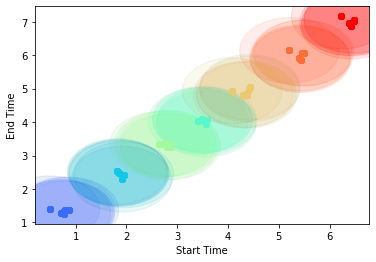

In [224]:
model, clusters,  data_processed, silhoutte = label_clusters(DBSCAN_auto_dis_builder_min_dis2, "XC552343_-_Screaming_Piha_-_Lipaugus_vociferans.mp3", distance = 1/2, verbose=True)

In [225]:
def compute_unique_user_count(data_oi,clusters):
  adv_cluster_count = 0
  adv_num_unique_users = 0 
  for i in range(max(clusters)):
     temp = data_oi[data_oi["cluster"] == i]
     adv_cluster_count += len(temp)
     adv_num_unique_users += len(pd.unique(temp['LAST MOD BY']))
  adv_cluster_count /= max(clusters)
  adv_num_unique_users /=  max(clusters)
  print("adverage cluster size: ", adv_cluster_count)
  print("adverage unqiue users per cluster size: ", adv_num_unique_users)
  return adv_num_unique_users


In [226]:
compute_unique_user_count(data_processed,clusters)

adverage cluster size:  6.0
adverage unqiue users per cluster size:  6.0


6.0

neighborhood size:  0.981324115672289
[0 1 2 3 4 5 6 3 1 0 2 5 4 6 1 0 2 3 5 6 4 1 3 0 2 4 5 6 3 5 4 2 1 0 6 1 0
 5 3 2 4 6]
adverage cluster size:  5.142857142857143
adverage unqiue users per cluster size:  5.142857142857143
Variance Ratio Criterion 1286.9291403172977
Note that VRC is less for DBSCAN in general
Silhoutte Score              :  0.9133627832779794
Silhoutte Score scaled 0 - 1 :  0.9566813916389897
scaled avg Silhoutte users   :  0.9069121243909235


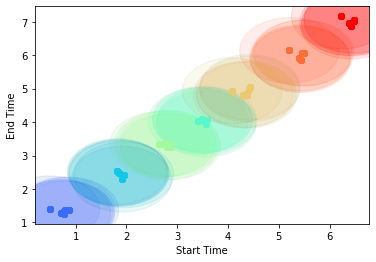

In [227]:
v =label_clusters(DBSCAN_auto_dis_builder_min_dis2, "XC552343_-_Screaming_Piha_-_Lipaugus_vociferans.mp3", distance = 1/2, verbose=True)


neighborhood size:  0.7422332382748698
[ 0  1  2  1 -1  3  0 -1  3 -1  2 -1]
adverage cluster size:  1.5
adverage unqiue users per cluster size:  1.5
Variance Ratio Criterion 1.7415615235635071
Note that VRC is less for DBSCAN in general
Silhoutte Score              :  0.6584675779029451
Silhoutte Score scaled 0 - 1 :  0.8292337889514725
scaled avg Silhoutte users   :  0.6021168944757362


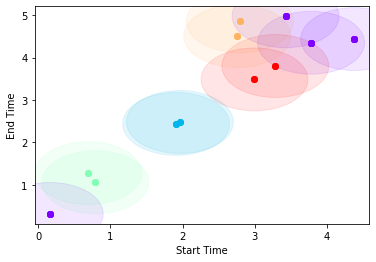

In [228]:
v= label_clusters(DBSCAN_auto_dis_builder_min_dis2, "XC591821_-_Screaming_Piha_-_Lipaugus_vociferans.mp3", verbose=True)

neighborhood size:  0.8240679947674229
[ 0  1  2 -1 -1  3 -1 -1 -1  4 -1  4 -1  0 -1  3 -1  2  1  0  0  3  2]
adverage cluster size:  2.4
adverage unqiue users per cluster size:  2.4
Variance Ratio Criterion 5.272671713222297
Note that VRC is less for DBSCAN in general
Silhoutte Score              :  0.5834935091946515
Silhoutte Score scaled 0 - 1 :  0.7917467545973258
scaled avg Silhoutte users   :  0.5958733772986629


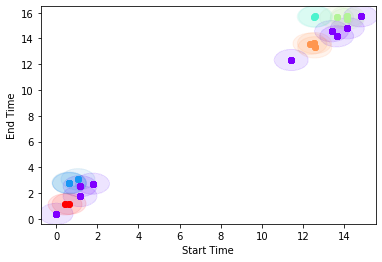

In [229]:
v =label_clusters(DBSCAN_auto_dis_builder_min_dis2, "XC425555_-_Screaming_Piha_-_Lipaugus_vociferans.mp3", verbose=True)

In [230]:
v= label_clusters(DBSCAN_auto_dis_builder_min_dis2, "XC591821_-_Screaming_Piha_-_Lipaugus_vociferans.mp3", iterate_users=True, n=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

mean silhoutte score for each # of sampled users from 1 to all users over 100 samples: [0.18317465075456338]
mean silhoutte score + unique_users/all users over 100 random samples for each # users: [0.09158732537728169]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

mean silhoutte score for each # of sampled users from 1 to all users over 100 samples: [0.18317465075456338, 0.4651570398594608]
mean silhoutte score + unique_users/all users over 100 random samples for each # users: [0.09158732537728169, 0.3117451865963971]
mean silhoutte score for each # of sampled users from 1 to all users over 100 samples: [0.18317465075456338, 0.4651570398594608, 0.6267218889900262]
mean silhoutte score + unique_users/all users over 100 random samples for each # users: [0.09158732537728169, 0.3117451865963971, 0.42891650005056886]
mean silhoutte score for each # of sampled users from 1 to all users over 100 samples: [0.18317465075456338, 0.4651570398594608, 0.6267218889900262, 0.6584675779029462]
mean silhoutte score + unique_users/all users over 100 random samples for each # users: [0.09158732537728169, 0.3117451865963971, 0.42891650005056886, 0.5167337889514719]


In [231]:
v =label_clusters(DBSCAN_auto_dis_builder_min_dis2, "XC425555_-_Screaming_Piha_-_Lipaugus_vociferans.mp3", iterate_users=True, n=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

mean silhoutte score for each # of sampled users from 1 to all users over 100 samples: [0.10777563893617266]
mean silhoutte score + unique_users/all users over 100 random samples for each # users: [0.05388781946808633]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

mean silhoutte score for each # of sampled users from 1 to all users over 100 samples: [0.10777563893617266, 0.6069875859193646]
mean silhoutte score + unique_users/all users over 100 random samples for each # users: [0.05388781946808633, 0.4795354596263494]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

mean silhoutte score for each # of sampled users from 1 to all users over 100 samples: [0.10777563893617266, 0.6069875859193646, 0.5759941100792976]
mean silhoutte score + unique_users/all users over 100 random samples for each # users: [0.05388781946808633, 0.4795354596263494, 0.49577483281742674]
mean silhoutte score for each # of sampled users from 1 to all users over 100 samples: [0.10777563893617266, 0.6069875859193646, 0.5759941100792976, 0.5837031976435685]
mean silhoutte score + unique_users/all users over 100 random samples for each # users: [0.05388781946808633, 0.4795354596263494, 0.49577483281742674, 0.502059932155118]
mean silhoutte score for each # of sampled users from 1 to all users over 100 samples: [0.10777563893617266, 0.6069875859193646, 0.5759941100792976, 0.5837031976435685, 0.5571537634448528]
mean silhoutte score + unique_users/all users over 100 random samples for each # users: [0.05388781946808633, 0.4795354596263494, 0.49577483281742674, 0.502059932155118, 0.

In [219]:
v= label_clusters(DBSCAN_auto_dis_builder_min_dis2, "XC552343_-_Screaming_Piha_-_Lipaugus_vociferans.mp3", iterate_users=True, n=100)

0
0
0
0
0
0
0
0
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
0
0
0
0
0
0
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
0
0
0
0
0
0
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
0
0
0
0
0
0
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
0
0
0
0
0
0
0
0
0
0
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

0
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
0
0
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
0
0
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
0
0
0
0
0
0
0
0
0
0
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

0
0
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
0
0
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
0
0
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
0
0
0
0
0
0
0
0
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
0
0
1 0.0 0.24015587848346912
0.24015587848346912
0.24015587848346912
0
0
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
0
0
0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

0
0
0
0
0
0
0
0
0
0
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
1 0.0 0.24106594709794527
0.24106594709794527
0.24106594709794527
0
0
0
0
0
0
0
0
0
0
0
0
mean silhoutte score for each # of sampled users from 1 to all users over 100 samples: [0.1395088259878864]
mean silhoutte score + unique_users/all users over 100 random samples for each # users: [0.0697544129939432]
2 0.8333333333333334 0.8223516415648202
0.8223516415648202
0.8223516415648202
2 0.8571428571428571 0.8958392757629681
0.8958392757629681
0.8958392757629681
2 0.8333333333333334 0.822753520428185
0.822753520428185
0.822753520428185
2 0.8333333333333334 0.822753520428185
0.822753520428185
0.822753520428185


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

2 0.8333333333333334 0.8476964867694087
0.8476964867694087
0.8476964867694087
2 0.8571428571428571 0.895856132057602
0.895856132057602
0.895856132057602
2 0.8571428571428571 0.9070146681264277
0.9070146681264277
0.9070146681264277
2 0.8571428571428571 0.8586521179009801
0.8586521179009801
0.8586521179009801
2 0.8571428571428571 0.8947668680786169
0.8947668680786169
0.8947668680786169
2 0.8571428571428571 0.8904457329228967
0.8904457329228967
0.8904457329228967
2 0.8571428571428571 0.8518819640417656
0.8518819640417656
0.8518819640417656
2 0.8571428571428571 0.8958392757629681
0.8958392757629681
0.8958392757629681
2 0.8333333333333334 0.8476964867694087
0.8476964867694087
0.8476964867694087
2 0.8333333333333334 0.822753520428185
0.822753520428185
0.822753520428185
2 0.8333333333333334 0.8476964867694087
0.8476964867694087
0.8476964867694087
2 0.8571428571428571 0.8518819640417656
0.8518819640417656
0.8518819640417656
2 0.8571428571428571 0.8958392757629681
0.8958392757629681
0.895839275